<a href="https://colab.research.google.com/github/Method-for-Software-System-Development/Cloud_Computing/blob/develop/logic/Bigdata_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Firebase Setup
This cell establishes the connection to Firebase Realtime Database by:
- Cloning the Cloud Computing project repository from GitHub
- Installing the `importnb` package to import Jupyter notebooks as Python modules
- Adding the firebase folder to the Python path
- Importing the FireBase module which contains authentication and configuration
- Setting up the `firebase_url` variable that will be used to access sensor



In [71]:
# Navigate to project folder and ensure we're on the 'develop' branch
import os, subprocess, sys

REPO_DIR = "/content/Cloud_Computing"
if not os.path.isdir(REPO_DIR):
    subprocess.run([
        "git", "clone", "-b", "develop",
        "https://github.com/Method-for-Software-System-Development/Cloud_Computing.git",
        REPO_DIR
    ], check=True)

# Update & checkout develop if repo already exists
subprocess.run(["git", "-C", REPO_DIR, "fetch", "origin"], check=True)
subprocess.run(["git", "-C", REPO_DIR, "checkout", "develop"], check=True)
subprocess.run(["git", "-C", REPO_DIR, "pull"], check=True)

# Install importnb (only needed once per session)
%pip install importnb --quiet

# Add firebase folder to Python path and import its notebook as module
sys.path.append(os.path.join(REPO_DIR, "firebase"))  # for FireBase.ipynb
sys.path.append(REPO_DIR)                            # for FAULT_RULES.ipynb
from importnb import Notebook

with Notebook():
    import FireBase as fb                           # now fb.add_user, fb.get_user, etc. are available


firebase_url = fb.firebase_url

# Spark Installation & Configuration
This cell sets up Apache Spark for big data processing in Google Colab:
- Installs Java 8
- Uses `pip install pyspark` instead of downloading large Spark binaries (Faster Installation)
- Initializes the Spark environment using `findspark`
- Creates a SparkSession with optimized configurations for Colab:
  - Adaptive query execution enabled for better performance
  - Reduced shuffle partitions (4) suitable for small-scale analysis
- The SparkSession serves as the entry point for all Spark operations including DataFrame creation, RDD operations, and SQL queries

This optimized setup ensures Spark runs efficiently in the cloud environment without timeout issues.

In [72]:
# Install Java and Spark (optimized for Google Colab)
import os

# Install Java (faster method)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!apt-get update -qq > /dev/null 2>&1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null 2>&1

# Install PySpark directly (much faster than downloading Spark manually)
!pip install -q pyspark findspark

# Initialize Spark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Firebase Sensor Data Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print("Spark initialized successfully!")

Spark initialized successfully!


# Data Fetching & Preparation
This cell handles the complete data pipeline from Firebase to Spark:

**Data Fetching:**
- Connects to Firebase Realtime Database using REST API
- Retrieves sensor data from `indoor` and `outdoor` collections
- Handles HTTP requests and JSON parsing

**Data Cleaning & Transformation:**
- Removes location prefixes ("Indoor ", "Outdoor ") from sensor field names
- Converts string values to numeric types where possible
- Handles "N/A" values and missing data appropriately
- Extracts hour and date information from timestamps for temporal analysis

**Spark Integration:**
- Converts cleaned Python data to Pandas DataFrame
- Creates Spark DataFrame for distributed processing
- Displays schema and sample data for verification

This preparation stage is crucial for ensuring data quality and compatibility with Spark's distributed computing framework.

In [73]:
import requests
import pandas as pd
from pyspark.sql.functions import col, avg, max as spark_max, min as spark_min, count
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_sensor_readings(subfolder):
    url = f"{firebase_url}sensor_readings/{subfolder}.json"
    print(f"Fetching data from: {url}")
    res = requests.get(url)
    return res.json() if res.ok else {}

def flatten_sensor_entries(data, location):
    records = []
    for timestamp, readings in data.items():
        if isinstance(readings, dict):
            clean_readings = {}
            for key, val in readings.items():
                # Remove "Indoor " or "Outdoor " from field name and clean up
                clean_key = key.replace("Indoor ", "").replace("Outdoor ", "").replace(" ", "_").lower()
                # Convert string values to float if possible
                try:
                    if val != "N/A" and val is not None:
                        clean_readings[clean_key] = float(val)
                    else:
                        clean_readings[clean_key] = None
                except (ValueError, TypeError):
                    clean_readings[clean_key] = val

            # Parse timestamp
            try:
                dt = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S")
                clean_readings["hour"] = dt.hour
                clean_readings["date"] = dt.date().isoformat()
            except:
                clean_readings["hour"] = None
                clean_readings["date"] = None

            records.append({
                "timestamp": timestamp,
                "location": location,
                **clean_readings
            })
    return records

# Fetch and flatten data
print("Fetching indoor data...")
indoor_data = flatten_sensor_entries(fetch_sensor_readings("indoor"), "indoor")
print(f"Indoor records: {len(indoor_data)}")

print("Fetching outdoor data...")
outdoor_data = flatten_sensor_entries(fetch_sensor_readings("outdoor"), "outdoor")
print(f"Outdoor records: {len(outdoor_data)}")

all_data = indoor_data + outdoor_data
print(f"Total records: {len(all_data)}")

# Convert to Spark DataFrame
df = spark.createDataFrame(pd.DataFrame(all_data))
df.printSchema()
df.show(5, truncate=False)

Fetching indoor data...
Fetching data from: https://optiline-kakado-default-rtdb.europe-west1.firebasedatabase.app/sensor_readings/indoor.json
Indoor records: 388
Fetching outdoor data...
Fetching data from: https://optiline-kakado-default-rtdb.europe-west1.firebasedatabase.app/sensor_readings/outdoor.json
Outdoor records: 330
Total records: 718
root
 |-- timestamp: string (nullable = true)
 |-- location: string (nullable = true)
 |-- distance: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- hour: long (nullable = true)
 |-- date: string (nullable = true)
 |-- dlight: double (nullable = true)

+-------------------+--------+--------+--------+--------+-----------+----+----------+------+
|timestamp          |location|distance|humidity|pressure|temperature|hour|date      |dlight|
+-------------------+--------+--------+--------+--------+-----------+----+----------+------+
|2025-05-18 06:

# MapReduce Analysis 1: Temperature by Location
Implements MapReduce pattern to calculate average temperature for each location (indoor vs outdoor).

**MapReduce Components:**
- **Map Phase:** `map_temp_location()` extracts (location, temperature) pairs from each sensor reading
- **Reduce Phase:** `reduce_temp_avg()` aggregates temperature values and counts for averaging
- **Final Transformation:** Calculates final averages by dividing sum by count

**Distributed Processing:**
- Converts Spark DataFrame to RDD for low-level MapReduce operations
- Uses `flatMap()` to handle multiple outputs per input record
- Uses `reduceByKey()` for efficient distributed aggregation
- Collects results back to driver for display

This analysis demonstrates classic MapReduce pattern for aggregating sensor data across different physical locations.

=== MAPREDUCE ANALYSIS 1: TEMPERATURE (INDOOR & OUTDOOR) ===
Temperature Statistics by Location:
Outdoor:
  Average: 28.32 °C
  Min: 24.40 °C
  Max: 32.96 °C
  Range: 8.56 °C
Indoor:
  Average: 26.61 °C
  Min: 23.95 °C
  Max: 28.84 °C
  Range: 4.89 °C


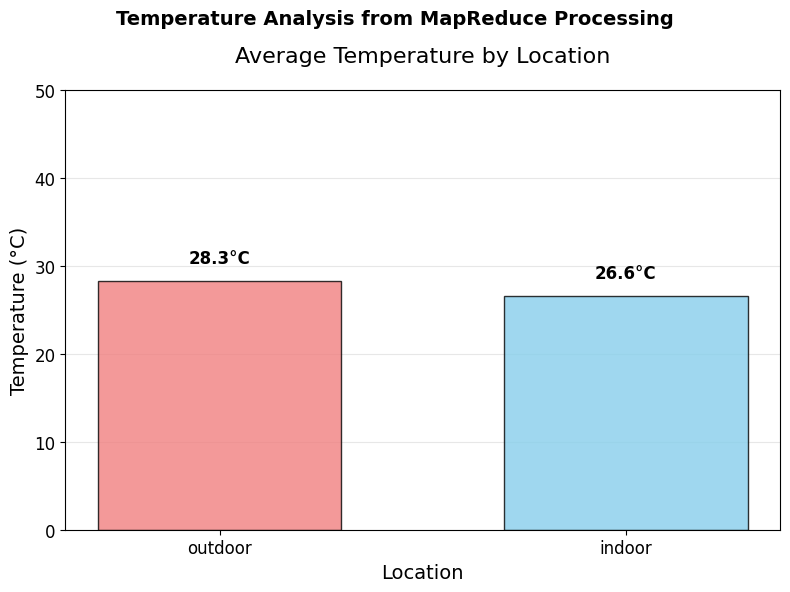

In [74]:
# MapReduce Analysis 1: Temperature Statistics (Indoor & Outdoor)
print("=== MAPREDUCE ANALYSIS 1: TEMPERATURE (INDOOR & OUTDOOR) ===")

# Create RDD for MapReduce operations
rdd = df.rdd

# MapReduce function for temperature statistics
def map_temperature_stats(row):
    """Map function for temperature statistics"""
    if row.temperature is not None and not pd.isna(row.temperature):
        return [(row.location, row.temperature)]
    return []

# Execute MapReduce for temperature statistics
temperature_rdd = rdd.flatMap(map_temperature_stats)
temperature_by_location = temperature_rdd.groupByKey()

print("Temperature Statistics by Location:")
temp_stats = {}
for location, temperatures in temperature_by_location.collect():
    temp_list = list(temperatures)
    if temp_list:
        avg_temp = sum(temp_list) / len(temp_list)
        min_temp = min(temp_list)
        max_temp = max(temp_list)
        temp_stats[location] = {
            'avg': avg_temp,
            'min': min_temp,
            'max': max_temp,
            'range': max_temp - min_temp,
            'values': temp_list
        }

        print(f"{location.capitalize()}:")
        print(f"  Average: {avg_temp:.2f} °C")
        print(f"  Min: {min_temp:.2f} °C")
        print(f"  Max: {max_temp:.2f} °C")
        print(f"  Range: {max_temp - min_temp:.2f} °C")
    else:
        temp_stats[location] = {
            'avg': float('nan'),
            'min': float('nan'),
            'max': float('nan'),
            'range': float('nan'),
            'values': []
        }
        print(f"{location.capitalize()}:")
        print(f"  Average: nan °C")
        print(f"  Min: nan °C")
        print(f"  Max: nan °C")
        print(f"  Range: nan °C")

# Plot Temperature Statistics
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Temperature Analysis from MapReduce Processing', fontsize=14, fontweight='bold')

# Bar plot for averages - only plot locations with data
locations_with_data = []
avg_temps_with_data = []
colors_with_data = []
color_map = {'indoor': 'skyblue', 'outdoor': 'lightcoral'}

for location in temp_stats.keys():
    if not pd.isna(temp_stats[location]['avg']):
        locations_with_data.append(location)
        avg_temps_with_data.append(temp_stats[location]['avg'])
        colors_with_data.append(color_map[location])

if locations_with_data:
    bar_width = 0.4 if len(locations_with_data) == 1 else 0.6
    bars1 = ax1.bar(locations_with_data, avg_temps_with_data, color=colors_with_data, width=bar_width,
                    edgecolor='black', linewidth=1, alpha=0.8)
    ax1.set_title('Average Temperature by Location', fontsize=16, pad=20)
    ax1.set_ylabel('Temperature (°C)', fontsize=14)
    ax1.set_ylim(0, 50)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)

    # Better text positioning and styling
    for i, (loc, avg) in enumerate(zip(locations_with_data, avg_temps_with_data)):
        ax1.text(i, avg + 1.5, f'{avg:.1f}°C', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    ax1.set_xlabel('Location', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
else:
    ax1.text(0.5, 0.5, 'No Temperature Data Available', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Average Temperature by Location')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_ylim(0, 50)

plt.tight_layout()
plt.show()

# MapReduce Analysis 2: Humidity Patterns by Hour
Analyzes humidity patterns across different hours of the day using MapReduce for temporal data analysis.

**Complex Key Mapping:**
- **Map Phase:** `map_humidity_hour()` creates composite keys (hour, location) for multi-dimensional analysis
- **Temporal Analysis:** Groups humidity readings by hour of day to identify daily patterns
- **Location Comparison:** Compares humidity trends between indoor and outdoor environments

**MapReduce Workflow:**
- Extracts hour information from parsed timestamps
- Creates (hour, location) composite keys for grouping
- Reuses the same reduce function for calculating averages
- Sorts results chronologically for pattern identification

**Use Case:** Identifies peak humidity hours, compares indoor vs outdoor humidity cycles, and reveals daily environmental patterns that could be useful for HVAC optimization or weather prediction.


=== MAPREDUCE ANALYSIS 2: HUMIDITY (INDOOR & OUTDOOR) ===
Humidity Statistics by Location:
Outdoor:
  Average: 49.82 %
  Min: 38.59 %
  Max: 59.26 %
  Range: 20.67 %
Indoor:
  Average: 42.77 %
  Min: 34.13 %
  Max: 52.53 %
  Range: 18.40 %


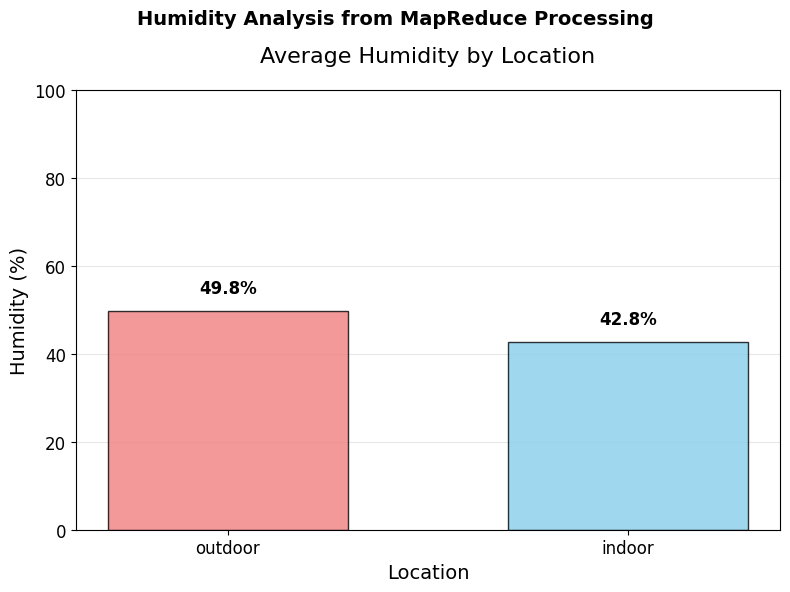

In [75]:
# MapReduce Analysis 2: Humidity Statistics (Indoor & Outdoor)
print("\n=== MAPREDUCE ANALYSIS 2: HUMIDITY (INDOOR & OUTDOOR) ===")

def map_humidity_stats(row):
    """Map function for humidity statistics"""
    if row.humidity is not None and not pd.isna(row.humidity):
        return [(row.location, row.humidity)]
    return []

# Execute MapReduce for humidity statistics
humidity_rdd = rdd.flatMap(map_humidity_stats)
humidity_by_location = humidity_rdd.groupByKey()

print("Humidity Statistics by Location:")
humidity_stats = {}
for location, humidities in humidity_by_location.collect():
    humidity_list = list(humidities)
    if humidity_list:
        avg_humidity = sum(humidity_list) / len(humidity_list)
        min_humidity = min(humidity_list)
        max_humidity = max(humidity_list)
        humidity_stats[location] = {
            'avg': avg_humidity,
            'min': min_humidity,
            'max': max_humidity,
            'range': max_humidity - min_humidity,
            'values': humidity_list
        }

        print(f"{location.capitalize()}:")
        print(f"  Average: {avg_humidity:.2f} %")
        print(f"  Min: {min_humidity:.2f} %")
        print(f"  Max: {max_humidity:.2f} %")
        print(f"  Range: {max_humidity - min_humidity:.2f} %")
    else:
        humidity_stats[location] = {
            'avg': float('nan'),
            'min': float('nan'),
            'max': float('nan'),
            'range': float('nan'),
            'values': []
        }
        print(f"{location.capitalize()}:")
        print(f"  Average: nan %")
        print(f"  Min: nan %")
        print(f"  Max: nan %")
        print(f"  Range: nan %")

# Plot Humidity Statistics
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Humidity Analysis from MapReduce Processing', fontsize=14, fontweight='bold')

# Bar plot for averages - only plot locations with data
locations_with_data = []
avg_humidity_with_data = []
colors_with_data = []
color_map = {'indoor': 'skyblue', 'outdoor': 'lightcoral'}

for location in humidity_stats.keys():
    if not pd.isna(humidity_stats[location]['avg']):
        locations_with_data.append(location)
        avg_humidity_with_data.append(humidity_stats[location]['avg'])
        colors_with_data.append(color_map[location])

if locations_with_data:
    bar_width = 0.4 if len(locations_with_data) == 1 else 0.6
    bars1 = ax1.bar(locations_with_data, avg_humidity_with_data, color=colors_with_data, width=bar_width,
                    edgecolor='black', linewidth=1, alpha=0.8)
    ax1.set_title('Average Humidity by Location', fontsize=16, pad=20)
    ax1.set_ylabel('Humidity (%)', fontsize=14)
    ax1.set_ylim(0, 100)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)

    # Better text positioning and styling
    for i, (loc, avg) in enumerate(zip(locations_with_data, avg_humidity_with_data)):
        ax1.text(i, avg + 3, f'{avg:.1f}%', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    ax1.set_xlabel('Location', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
else:
    ax1.text(0.5, 0.5, 'No Humidity Data Available', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Average Humidity by Location')
    ax1.set_ylabel('Humidity (%)')
    ax1.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# MapReduce Analysis 3: Distance Statistics
Calculates comprehensive pressure statistics (min, max, average, range) for each location using MapReduce operations.

**Statistical Analysis:**
- **Map Phase:** `map_pressure_stats()` extracts location-pressure pairs for statistical computation
- **Group Operation:** Uses `groupByKey()` to collect all pressure readings per location
- **Statistical Metrics:** Computes min, max, average, and range for comprehensive analysis

**Advanced MapReduce Pattern:**
- Demonstrates alternative to `reduceByKey()` using `groupByKey()` for cases where multiple statistics are needed
- Processes grouped data locally after collection for complex calculations
- Provides insights into environmental pressure variations between locations

**Practical Applications:** Pressure differences can indicate altitude variations, weather patterns, or HVAC system performance. Range calculations help identify sensor stability and environmental consistency.


=== MAPREDUCE ANALYSIS 3: DISTANCE (INDOOR ONLY) ===
Distance Statistics (Indoor Only):
Indoor:
  Average: 668.10 mm
  Min: 210.12 mm
  Max: 1730.83 mm
  Range: 1520.71 mm


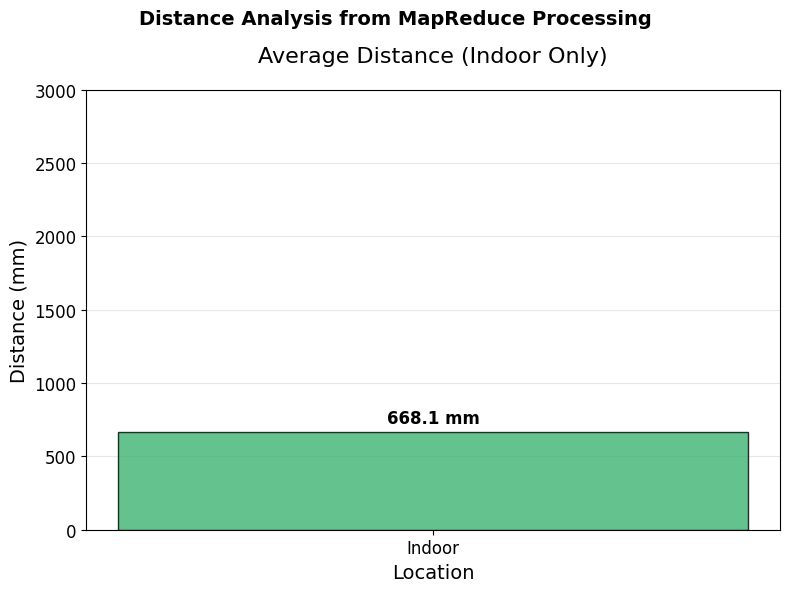

In [83]:
# MapReduce Analysis 3: Distance Statistics (Indoor Only)
print("\n=== MAPREDUCE ANALYSIS 3: DISTANCE (INDOOR ONLY) ===")

def map_distance_stats(row):
    """Map function for distance statistics - indoor only"""
    if (row.location == 'indoor' and
        hasattr(row, 'distance') and
        row.distance is not None and
        not pd.isna(row.distance)):
        return [('indoor', row.distance)]
    return []

# Execute MapReduce for distance statistics
distance_rdd = rdd.flatMap(map_distance_stats)
distance_by_location = distance_rdd.groupByKey()

print("Distance Statistics (Indoor Only):")
distance_stats = {}
for location, distances in distance_by_location.collect():
    distance_list = list(distances)
    if distance_list:
        avg_distance = sum(distance_list) / len(distance_list)
        min_distance = min(distance_list)
        max_distance = max(distance_list)
        distance_stats[location] = {
            'avg': avg_distance,
            'min': min_distance,
            'max': max_distance,
            'range': max_distance - min_distance,
            'values': distance_list
        }

        print(f"{location.capitalize()}:")
        print(f"  Average: {avg_distance:.2f} mm")
        print(f"  Min: {min_distance:.2f} mm")
        print(f"  Max: {max_distance:.2f} mm")
        print(f"  Range: {max_distance - min_distance:.2f} mm")
    else:
        distance_stats['indoor'] = {
            'avg': float('nan'),
            'min': float('nan'),
            'max': float('nan'),
            'range': float('nan'),
            'values': []
        }
        print("Indoor:")
        print("  Average: nan mm")
        print("  Min: nan mm")
        print("  Max: nan mm")
        print("  Range: nan mm")

# Plot Distance Statistics
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Distance Analysis from MapReduce Processing', fontsize=14, fontweight='bold')

# Check if there's data to plot
has_data = 'indoor' in distance_stats and not pd.isna(distance_stats['indoor']['avg'])

if has_data:
    bars1 = ax1.bar(['Indoor'], [distance_stats['indoor']['avg']],
                    color='mediumseagreen', width=0.4,
                    edgecolor='black', linewidth=1, alpha=0.8)
    ax1.set_title('Average Distance (Indoor Only)', fontsize=16, pad=20)
    ax1.set_ylabel('Distance (mm)', fontsize=14)
    ax1.set_ylim(0, 3000)  # Set y-axis from 0 to 30mm (3cm)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)

    # Add value label
    ax1.text(0, distance_stats['indoor']['avg'] + distance_stats['indoor']['avg'] * 0.05,
             f'{distance_stats["indoor"]["avg"]:.1f} mm', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

    ax1.set_xlabel('Location', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
else:
    ax1.text(0.5, 0.5, 'No Distance Data Available', ha='center', va='center',
             transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Average Distance (Indoor Only)')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_ylim(0, 3000)

plt.tight_layout()
plt.show()


=== MAPREDUCE ANALYSIS 4: PRESSURE (INDOOR ONLY) ===
Pressure Statistics (Indoor Only):
Indoor:
  Average: 976.85 hPa
  Min: 976.06 hPa
  Max: 977.95 hPa
  Range: 1.89 hPa


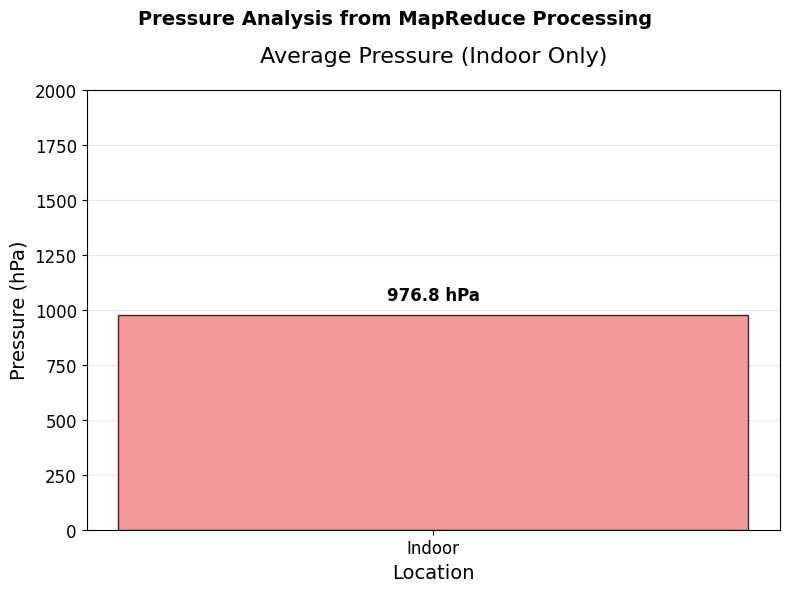

In [77]:
# MapReduce Analysis 4: Pressure Statistics (Indoor Only)
print("\n=== MAPREDUCE ANALYSIS 4: PRESSURE (INDOOR ONLY) ===")

def map_pressure_stats(row):
    """Map function for pressure statistics - indoor only"""
    if (row.location == 'indoor' and
        hasattr(row, 'pressure') and
        row.pressure is not None and
        not pd.isna(row.pressure)):
        return [('indoor', row.pressure)]
    return []

# Execute MapReduce for pressure statistics
pressure_rdd = rdd.flatMap(map_pressure_stats)
pressure_by_location = pressure_rdd.groupByKey()

print("Pressure Statistics (Indoor Only):")
pressure_stats = {}
for location, pressures in pressure_by_location.collect():
    pressure_list = list(pressures)
    if pressure_list:
        avg_pressure = sum(pressure_list) / len(pressure_list)
        min_pressure = min(pressure_list)
        max_pressure = max(pressure_list)
        pressure_stats[location] = {
            'avg': avg_pressure,
            'min': min_pressure,
            'max': max_pressure,
            'range': max_pressure - min_pressure,
            'values': pressure_list
        }

        print(f"{location.capitalize()}:")
        print(f"  Average: {avg_pressure:.2f} hPa")
        print(f"  Min: {min_pressure:.2f} hPa")
        print(f"  Max: {max_pressure:.2f} hPa")
        print(f"  Range: {max_pressure - min_pressure:.2f} hPa")
    else:
        pressure_stats['indoor'] = {
            'avg': float('nan'),
            'min': float('nan'),
            'max': float('nan'),
            'range': float('nan'),
            'values': []
        }
        print("Indoor:")
        print("  Average: nan hPa")
        print("  Min: nan hPa")
        print("  Max: nan hPa")
        print("  Range: nan hPa")

# Plot Pressure Statistics
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Pressure Analysis from MapReduce Processing', fontsize=14, fontweight='bold')

# Check if there's data to plot
has_data = 'indoor' in pressure_stats and not pd.isna(pressure_stats['indoor']['avg'])

if has_data:
    bars1 = ax1.bar(['Indoor'], [pressure_stats['indoor']['avg']],
                    color='lightcoral', width=0.4,
                    edgecolor='black', linewidth=1, alpha=0.8)
    ax1.set_title('Average Pressure (Indoor Only)', fontsize=16, pad=20)
    ax1.set_ylabel('Pressure (hPa)', fontsize=14)
    ax1.set_ylim(0, 2000)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)

    # Add value label
    ax1.text(0, pressure_stats['indoor']['avg'] + 50,
             f'{pressure_stats["indoor"]["avg"]:.1f} hPa', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

    ax1.set_xlabel('Location', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
else:
    ax1.text(0.5, 0.5, 'No Pressure Data Available', ha='center', va='center',
             transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Average Pressure (Indoor Only)')
    ax1.set_ylabel('Pressure (hPa)')
    ax1.set_ylim(0, 2000)

plt.tight_layout()
plt.show()


=== MAPREDUCE ANALYSIS 5: DLIGHT (OUTDOOR ONLY) ===
Dlight Statistics (Outdoor Only):
Outdoor:
  Average: 1672.40 lux
  Min: 108.00 lux
  Max: 3330.00 lux
  Range: 3222.00 lux


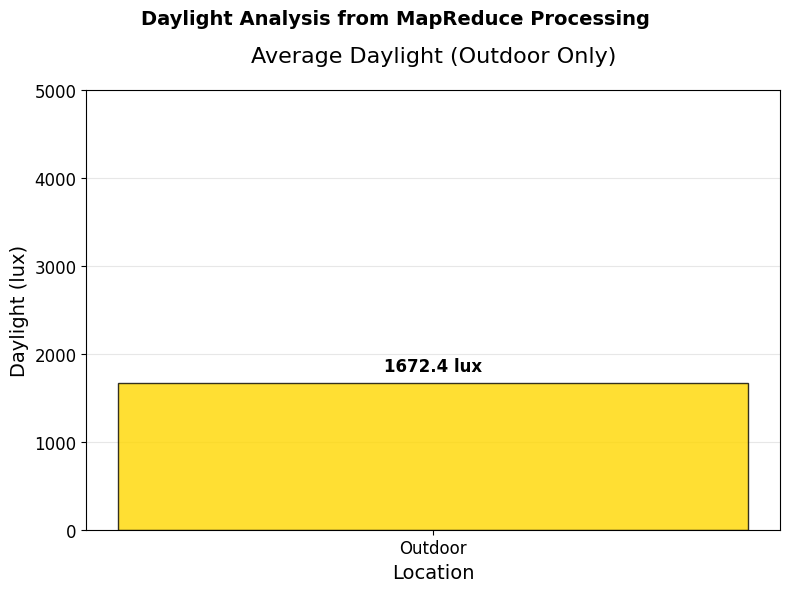

In [81]:
# MapReduce Analysis 5: Dlight Statistics (Outdoor Only)
print("\n=== MAPREDUCE ANALYSIS 5: DLIGHT (OUTDOOR ONLY) ===")

def map_dlight_stats(row):
    """Map function for dlight statistics - outdoor only"""
    if (row.location == 'outdoor' and
        hasattr(row, 'dlight') and
        row.dlight is not None and
        not pd.isna(row.dlight)):
        return [('outdoor', row.dlight)]
    return []

# Execute MapReduce for dlight statistics
dlight_rdd = rdd.flatMap(map_dlight_stats)
dlight_by_location = dlight_rdd.groupByKey()

print("Dlight Statistics (Outdoor Only):")
dlight_stats = {}
for location, dlights in dlight_by_location.collect():
    dlight_list = list(dlights)
    if dlight_list:
        avg_dlight = sum(dlight_list) / len(dlight_list)
        min_dlight = min(dlight_list)
        max_dlight = max(dlight_list)
        dlight_stats[location] = {
            'avg': avg_dlight,
            'min': min_dlight,
            'max': max_dlight,
            'range': max_dlight - min_dlight,
            'values': dlight_list
        }

        print(f"{location.capitalize()}:")
        print(f"  Average: {avg_dlight:.2f} lux")
        print(f"  Min: {min_dlight:.2f} lux")
        print(f"  Max: {max_dlight:.2f} lux")
        print(f"  Range: {max_dlight - min_dlight:.2f} lux")
    else:
        dlight_stats['outdoor'] = {
            'avg': float('nan'),
            'min': float('nan'),
            'max': float('nan'),
            'range': float('nan'),
            'values': []
        }
        print("Outdoor:")
        print("  Average: nan lux")
        print("  Min: nan lux")
        print("  Max: nan lux")
        print("  Range: nan lux")

# Plot Dlight Statistics
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Daylight Analysis from MapReduce Processing', fontsize=14, fontweight='bold')

# Check if there's data to plot
has_data = 'outdoor' in dlight_stats and not pd.isna(dlight_stats['outdoor']['avg'])

if has_data:
    bars1 = ax1.bar(['Outdoor'], [dlight_stats['outdoor']['avg']],
                    color='gold', width=0.4,
                    edgecolor='black', linewidth=1, alpha=0.8)
    ax1.set_title('Average Daylight (Outdoor Only)', fontsize=16, pad=20)
    ax1.set_ylabel('Daylight (lux)', fontsize=14)
    ax1.set_ylim(0, 5000)  # Set y-axis from 0 to 5000 lux
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)

    # Add value label
    ax1.text(0, dlight_stats['outdoor']['avg'] + dlight_stats['outdoor']['avg'] * 0.05,
             f'{dlight_stats["outdoor"]["avg"]:.1f} lux', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

    ax1.set_xlabel('Location', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
else:
    ax1.text(0.5, 0.5, 'No Daylight Data Available', ha='center', va='center',
             transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Average Daylight (Outdoor Only)')
    ax1.set_ylabel('Daylight (lux)')
    ax1.set_ylim(0, 5000)  # Set y-axis from 0 to 5000 lux

plt.tight_layout()
plt.show()

# Spark SQL Summary Statistics
Uses Spark SQL to generate detailed statistical summaries of all sensor data. Registers the DataFrame as a SQL table and runs queries to show record counts and statistics by location.

**SQL Analysis Features:**
- **Record Counting:** Shows data distribution across indoor and outdoor locations
- **Temperature Statistics:** Min, max, average, and count of temperature readings per location
- **Humidity Statistics:** Complete statistical summary of humidity measurements
- **Pressure Statistics:** Comprehensive pressure analysis (when data is available)

**Spark SQL Benefits:**
- Leverages familiar SQL syntax for data analysis
- Automatic query optimization through Spark's Catalyst optimizer
- Seamless integration with distributed computing framework
- Easy to read tabular output for statistical summaries

**Big Data Context:** This demonstrates how Spark SQL can handle large-scale sensor data analysis using standard SQL queries, making it accessible to analysts familiar with traditional database systems while benefiting from distributed computing capabilities.

In [87]:
# Spark SQL Summary Statistics - Using MapReduce Results
print("\n=== MAPREDUCE RESULTS SUMMARY ===")

# Create DataFrames from MapReduce results for table display
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# 1. Record Count by Location
print("\n📊 Record Count by Location:")
location_counts = []
for location in ['indoor', 'outdoor']:
    if location == 'indoor':
        count = len(indoor_data)
    else:
        count = len(outdoor_data)
    location_counts.append((location, count))

count_schema = StructType([
    StructField("location", StringType(), True),
    StructField("count", IntegerType(), True)
])
count_df = spark.createDataFrame(location_counts, count_schema)
count_df.show(truncate=False)

# 2. Temperature Statistics (if available)
if 'temp_stats' in globals() and any(not pd.isna(stats['avg']) for stats in temp_stats.values()):
    print("\n🌡️ Temperature Statistics (Indoor & Outdoor):")
    temp_results = []
    for location, stats in temp_stats.items():
        if not pd.isna(stats['avg']):
            temp_results.append((
                location,
                round(stats['avg'], 2),
                round(stats['min'], 2),
                round(stats['max'], 2),
                len(stats['values'])
            ))

    if temp_results:
        temp_schema = StructType([
            StructField("location", StringType(), True),
            StructField("avg_temp", DoubleType(), True),
            StructField("min_temp", DoubleType(), True),
            StructField("max_temp", DoubleType(), True),
            StructField("temp_readings", IntegerType(), True)
        ])
        temp_df = spark.createDataFrame(temp_results, temp_schema)
        temp_df.show(truncate=False)

# 3. Humidity Statistics (if available)
if 'humidity_stats' in globals() and any(not pd.isna(stats['avg']) for stats in humidity_stats.values()):
    print("\n💧 Humidity Statistics (Indoor & Outdoor):")
    humidity_results = []
    for location, stats in humidity_stats.items():
        if not pd.isna(stats['avg']):
            humidity_results.append((
                location,
                round(stats['avg'], 2),
                round(stats['min'], 2),
                round(stats['max'], 2),
                len(stats['values'])
            ))

    if humidity_results:
        humidity_schema = StructType([
            StructField("location", StringType(), True),
            StructField("avg_humidity", DoubleType(), True),
            StructField("min_humidity", DoubleType(), True),
            StructField("max_humidity", DoubleType(), True),
            StructField("humidity_readings", IntegerType(), True)
        ])
        humidity_df = spark.createDataFrame(humidity_results, humidity_schema)
        humidity_df.show(truncate=False)

# 4. Distance Statistics (Indoor Only, if available)
if 'distance_stats' in globals() and 'indoor' in distance_stats and not pd.isna(distance_stats['indoor']['avg']):
    print("\n📏 Distance Statistics (Indoor Only):")
    distance_results = [(
        'indoor',
        round(distance_stats['indoor']['avg'], 2),
        round(distance_stats['indoor']['min'], 2),
        round(distance_stats['indoor']['max'], 2),
        len(distance_stats['indoor']['values'])
    )]

    distance_schema = StructType([
        StructField("location", StringType(), True),
        StructField("avg_distance", DoubleType(), True),
        StructField("min_distance", DoubleType(), True),
        StructField("max_distance", DoubleType(), True),
        StructField("distance_readings", IntegerType(), True)
    ])
    distance_df = spark.createDataFrame(distance_results, distance_schema)
    distance_df.show(truncate=False)

# 5. Pressure Statistics (Indoor Only, if available)
if 'pressure_stats' in globals() and 'indoor' in pressure_stats and not pd.isna(pressure_stats['indoor']['avg']):
    print("\n🔘 Pressure Statistics (Indoor Only):")
    pressure_results = [(
        'indoor',
        round(pressure_stats['indoor']['avg'], 2),
        round(pressure_stats['indoor']['min'], 2),
        round(pressure_stats['indoor']['max'], 2),
        len(pressure_stats['indoor']['values'])
    )]

    pressure_schema = StructType([
        StructField("location", StringType(), True),
        StructField("avg_pressure", DoubleType(), True),
        StructField("min_pressure", DoubleType(), True),
        StructField("max_pressure", DoubleType(), True),
        StructField("pressure_readings", IntegerType(), True)
    ])
    pressure_df = spark.createDataFrame(pressure_results, pressure_schema)
    pressure_df.show(truncate=False)

# 6. Daylight Statistics (Outdoor Only, if available)
if 'dlight_stats' in globals() and 'outdoor' in dlight_stats and not pd.isna(dlight_stats['outdoor']['avg']):
    print("\n☀️ Daylight Statistics (Outdoor Only):")
    dlight_results = [(
        'outdoor',
        round(dlight_stats['outdoor']['avg'], 2),
        round(dlight_stats['outdoor']['min'], 2),
        round(dlight_stats['outdoor']['max'], 2),
        len(dlight_stats['outdoor']['values'])
    )]

    dlight_schema = StructType([
        StructField("location", StringType(), True),
        StructField("avg_dlight", DoubleType(), True),
        StructField("min_dlight", DoubleType(), True),
        StructField("max_dlight", DoubleType(), True),
        StructField("dlight_readings", IntegerType(), True)
    ])
    dlight_df = spark.createDataFrame(dlight_results, dlight_schema)
    dlight_df.show(truncate=False)

print("\nComplete MapReduce analysis finished successfully!")


=== MAPREDUCE RESULTS SUMMARY ===

📊 Record Count by Location:
+--------+-----+
|location|count|
+--------+-----+
|indoor  |388  |
|outdoor |330  |
+--------+-----+


🌡️ Temperature Statistics (Indoor & Outdoor):
+--------+--------+--------+--------+-------------+
|location|avg_temp|min_temp|max_temp|temp_readings|
+--------+--------+--------+--------+-------------+
|outdoor |28.32   |24.4    |32.96   |330          |
|indoor  |26.61   |23.95   |28.84   |337          |
+--------+--------+--------+--------+-------------+


💧 Humidity Statistics (Indoor & Outdoor):
+--------+------------+------------+------------+-----------------+
|location|avg_humidity|min_humidity|max_humidity|humidity_readings|
+--------+------------+------------+------------+-----------------+
|outdoor |49.82       |38.59       |59.26       |330              |
|indoor  |42.77       |34.13       |52.53       |179              |
+--------+------------+------------+------------+-----------------+


📏 Distance Statistic